# DSCI 100 Group Project

## Introduction

### Background Information
PLAICraft is a project undertaken by the Pacific Laboratory for AI Research at UBC. The group aims to build an embodied AI model, mimicking human behaviour in a virtual real world setting like Minecraft (PLAI 2024). To do this, the group hosts an online Minecraft server that records player actions (e.g. keypresses, mouse movements) and audio. In this project, demographic data was collected for 196 players, as well as data for specific sessions played by the players. 

### Summary
Upon inspection, the `players` dataset, in which each observation is a unique player, contains the following variables:
- `experience`, the self-reported experience level of each player: character string (should be categorical)
- `subscribe`, whether the player subscribed to a newsletter, a logical value.
- `hashedEmail`, a unique, untraceable identifier derived from the player's email: character string
- `played_hours`, how long they played PLAICraft, in hours: numeric 
- `gender`, their self-reported gender identity: character string
- `Age`, their self-reported age in years: numeric

Data for 196 unique players is included in this dataset.

`sessions`, in which each observation is a play session, contains:
- `hashedEmail` of the player who played the session
- `start_time` and `end_time`, timestamps for the beginning and end of the play session: character strings that should be date-times
- `original_start_time` and `original_end_time`, roughly the number of milliseconds between January 1, 1970, and the beginning/end of the play session. This is a numeric data type and is far to imprecise to be useful.

Data for 1535 play sessions is included in this dataset.

### Question
Can a player's age, Minecraft experience level, total play time, average session duration, and number of sessions played predict whether they will subscribe to a game-related newsletter?

### Exploratory Data Analysis

In [83]:
#loading libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(janitor)
library(themis)
library(cowplot)

options(repr.matrix.max.rows = 5)

Basic wrangling is performed on relevant parts of the data sets. The column titles are cleaned using the `janitor` package for easier reference and start and end times are converted from unusable character strings to date-time objects using the `lubridate` package.

In [2]:
sessions_url <- "https://raw.githubusercontent.com/YoyoLiu314/group-project/refs/heads/main/sessions.csv"
players_url <- "https://raw.githubusercontent.com/YoyoLiu314/group-project/refs/heads/main/players.csv"

players <- read_csv(players_url) |>
    clean_names() 
    

sessions <- read_csv(sessions_url) |>
    clean_names() |>   
    select(-starts_with("original")) |>
    mutate(start_time = dmy_hm(start_time), end_time = dmy_hm(end_time))



Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


The date-time data type allows the duration of each session to be calculated. As well, the number of sessions played by each player is counted and recorded.

In [84]:
durations <- sessions |>
    mutate(duration = end_time - start_time) |>
    group_by(hashed_email) |>
    summarize(mean = mean(duration, na.rm = TRUE), play_time = sum(duration, na.rm = TRUE), num_sessions = n()) 
durations

hashed_email,mean,play_time,num_sessions
<chr>,<drtn>,<drtn>,<int>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,53 mins,106 mins,2
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,30 mins,30 mins,1
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,11 mins,11 mins,1
⋮,⋮,⋮,⋮
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,9 mins,9 mins,1
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,72 mins,72 mins,1


Using the hashed emails as an identifier, the play session data for each player is reconciled with their demographic data. `left_join` is used in order to avoid dropping players who never played (as their hased email would not appear in the `sessions` dataset). This leaves NA values for play time and number of sessions played, which are replaced by 0s. Note that, while there is also an NA value in `age`, this cannot simply be replaced by 0. When modelling, this will be resolved by imputing it with the mean age.

In [85]:
players_joined <- left_join(players, durations) |>
    select(-hashed_email) |>
    mutate(play_time = as.numeric(play_time), mean = as.numeric(mean)) |>
    mutate(play_time = replace_na(play_time, 0), mean = replace_na(mean, 0), num_sessions = replace_na(num_sessions, 0)) 
players_joined

Joining with `by = join_by(hashed_email)`


experience,subscribe,played_hours,name,gender,age,mean,play_time,num_sessions
<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>
Pro,TRUE,30.3,Morgan,Male,9,74.77778,2019,27
Veteran,TRUE,3.8,Christian,Male,17,85.00000,255,3
Veteran,FALSE,0.0,Blake,Male,17,5.00000,5,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,2.3,Harlow,Male,17,29.83333,179,6
Pro,TRUE,0.2,Ahmed,Other,NA,15.00000,15,1


As experience levels are ordinal, we can assign numerical values for them. While this is not necessarily the most nuanced (as it assumes a linear scale for game experience), it is a reasonable way to make use of this data for predictive purposes.

In [86]:
players_numeric <- players_joined |>
    mutate(exp_num = case_when(experience == "Beginner" ~ 0, 
                               experience == "Amateur" ~ 1, 
                               experience == "Regular" ~ 2, 
                               experience == "Pro" ~ 3, 
                               experience == "Veteran" ~ 4)) |>
    select(subscribe, age, mean, play_time, exp_num, num_sessions, experience) |>
    mutate(subscribe = as_factor(subscribe), experience = as_factor(experience)) 
players_numeric

subscribe,age,mean,play_time,exp_num,num_sessions,experience
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
TRUE,9,74.77778,2019,3,27,Pro
TRUE,17,85.00000,255,4,3,Veteran
FALSE,17,5.00000,5,4,1,Veteran
⋮,⋮,⋮,⋮,⋮,⋮,⋮
FALSE,17,29.83333,179,1,6,Amateur
TRUE,NA,15.00000,15,3,1,Pro


## Preliminary Visualizations

### Justification
In this investigation, we chose to calculate `mean` and `num_sessions` because they offer information about play patterns. Rather than solely focusing on the total play time, we will be able to look at the players' frequency (how many times they log in to play) and their engagement per session (how long they stay when playing). Visualizing these variables highlight user patterns and may provide a better prediction of long-term interest and possibly subscription behaviour. We selected out the most illustrative relationships between variables to represent in our visualizations. Figs. 1 and 2 include both log and continuous scales - the log graph effectively filters out "non-players" and allows better visualization of those who played for only a short duration of time.

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


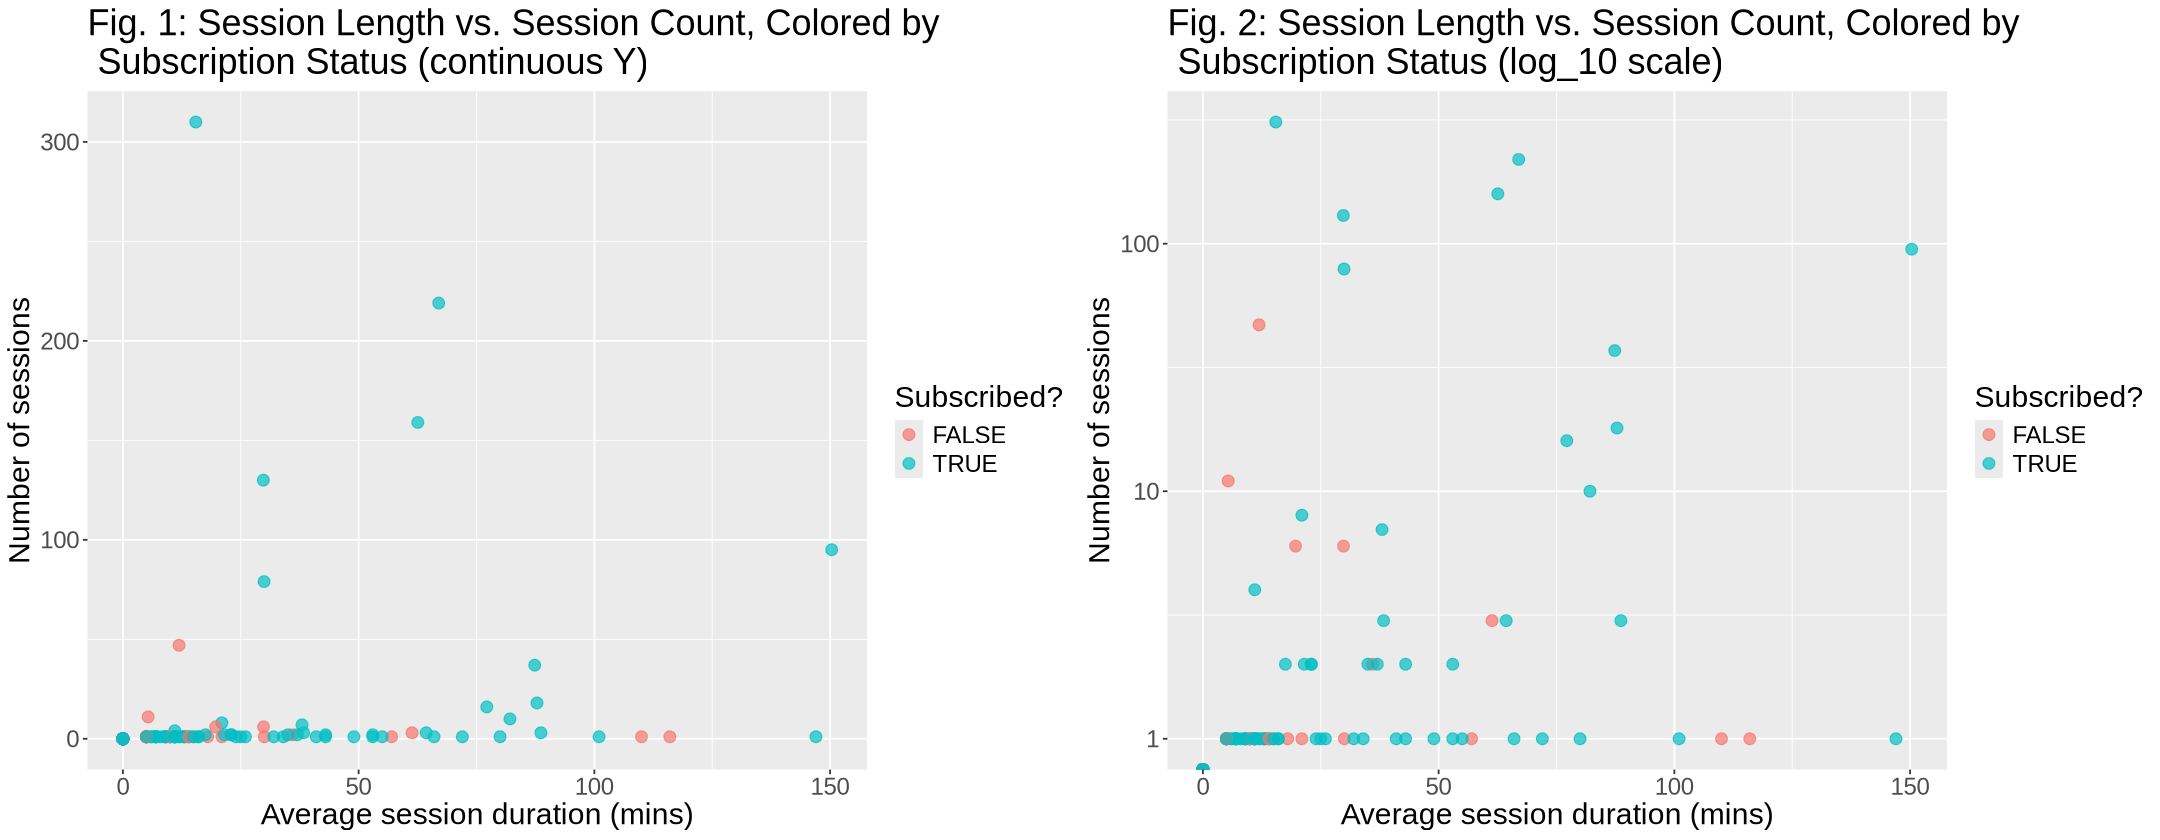

In [95]:
set.seed(1019)
# Split the data 
split <- initial_split(players_numeric, prop = 0.75)
play_train <- training(split)
play_test <- testing(split)

# Scatter plot for visualization (mean vs. num_sessions)
options(repr.plot.width = 18, repr.plot.height = 7)
length_count_plot <- ggplot(play_train, aes(x = mean, y = num_sessions, color = subscribe)) +
    geom_point(alpha = 0.7, size = 3) +
    labs(
        title = "Fig. 1: Session Length vs. Session Count, Colored by \n Subscription Status (continuous Y)",
        x = "Average session duration (mins)",
        y = "Number of sessions",
        color = "Subscribed?"
        ) +
    theme(text = element_text(size = 18))

length_count_log <- ggplot(play_train, aes(x = mean, y = num_sessions, color = subscribe)) +
    geom_point(alpha = 0.7, size = 3) +
    labs(
        title = "Fig. 2: Session Length vs. Session Count, Colored by \n Subscription Status (log_10 scale)",
        x = "Average session duration (mins)",
        y = "Number of sessions",
        color = "Subscribed?"
        ) +
     scale_y_log10() +
    theme(text = element_text(size = 18))
log_regular_plot <- plot_grid(length_count_plot, length_count_log)
   log_regular_plot


### Visual observations
Observing the scatter plot:
1. Most players are clustered near the bottom-left, indicating they play brief sessions and rarely. Many of these players are nevertheless subscribed to the newsletter.
2. Players with high average durations or very high session counts are almost all subscribers. Indicated on the plot, the top-right region and outlier regions (long and frequent players) are mostly blue, categorizing them as subscribers. While some players who played one long session or many short sessions did not subscribe, players in this data set who played a large number of long sessions (the top right) were all subscribers.

It appears that session duration and number of sessions may be predictive of subscription - while the pattern is not strong, K-NN classification requires few assumptions about what the data must look like and thus it should be able to take advantage of any patterns in this data should they exist.

We now consider whether Minecraft experience is predictive of subscription. As K-NN classification is sensitive to bad predictors, if experience appears not to have predictive value, it will be omitted from the model.

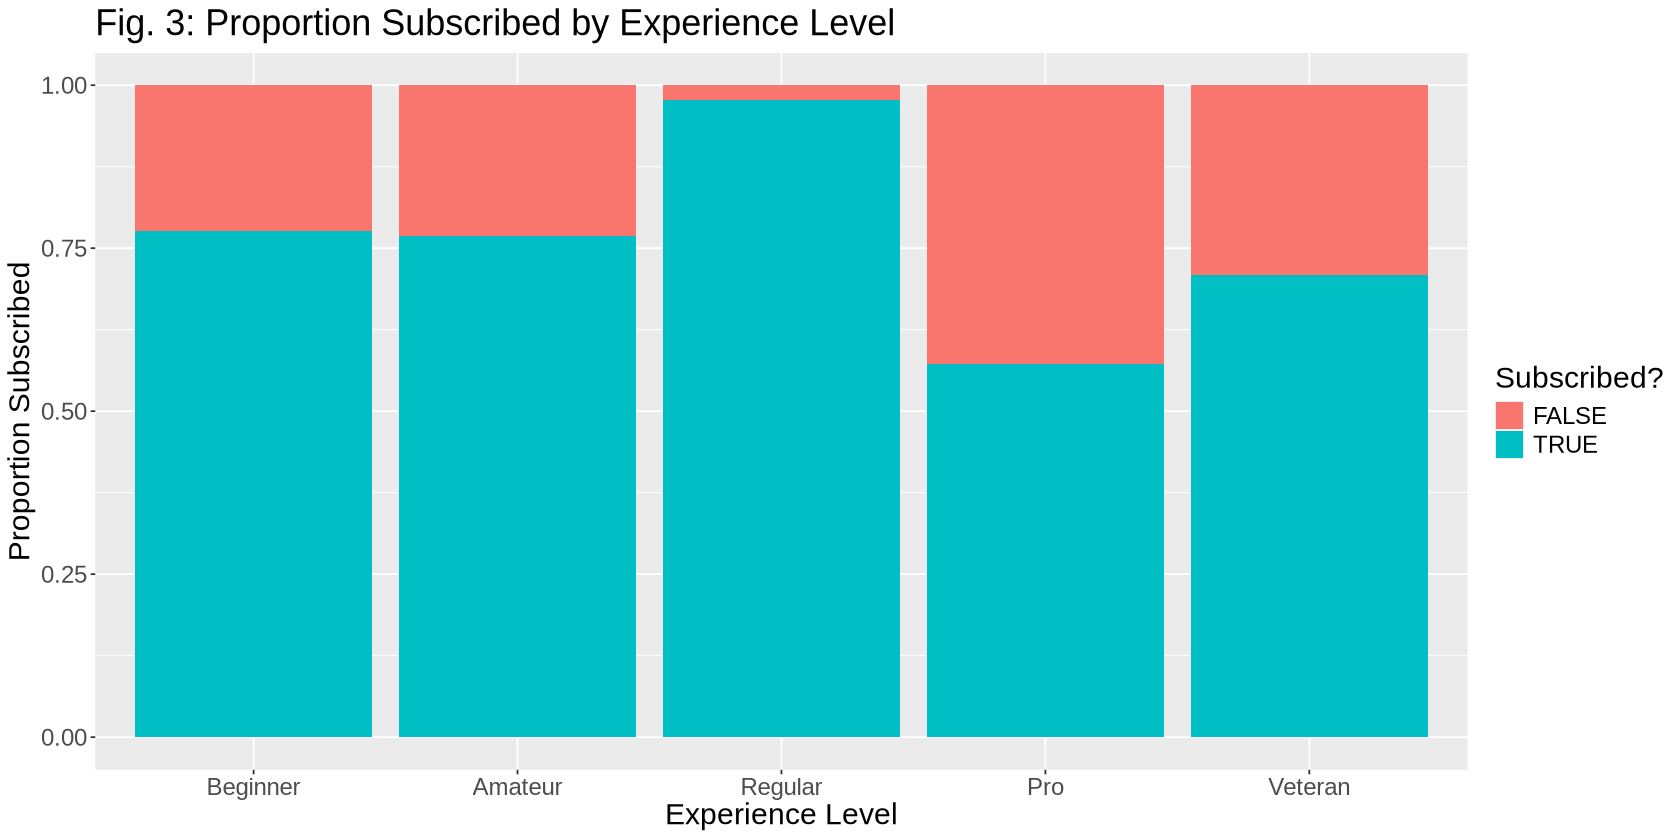

In [37]:
options(repr.plot.width = 14, repr.plot.height = 7)

play_train$experience <- factor(play_train$experience, levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran"))

exp_bar <- ggplot(play_train, aes(x = experience, y = mean, fill = subscribe)) +
    geom_bar(stat = "identity", position = "fill") +
    labs(title = "Fig. 3: Proportion Subscribed by Experience Level",
         x = "Experience Level", 
         y = "Proportion Subscribed",
        fill = "Subscribed?") +
    theme(text = element_text(size = 18))
exp_bar


Notably, "Regular" players seem to subscribe at much higher rates than other experience levels, while "Pro" players subcribe at a lower rate. This indicates that experience level may be correlated with subscription status, and as K-NN can make use of any patterns that may exist in the data, experience level will be used as a predictor. Note that the overall percentage of subscribed players in the training data is 73%, and only "Regular" and "Pro" players differ significantly from this average.

Finally, we will consider age as a predictor using a histogram. This will show the age distribution of the playerbase as well as of subscribers and non-subscribers.

Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_bin()`).”


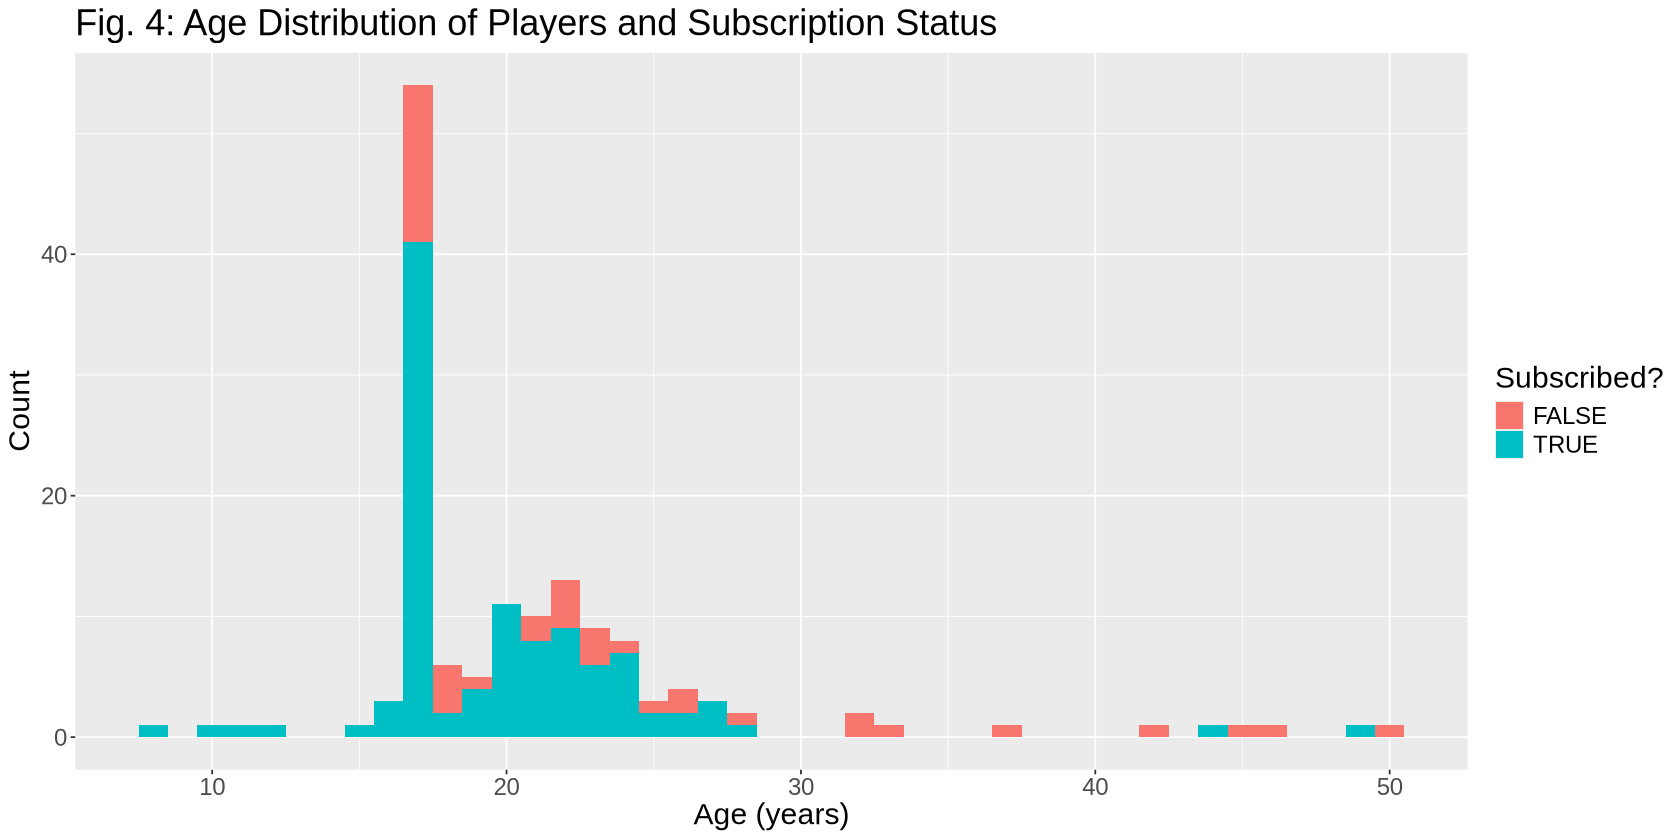

In [38]:
age_plot <- play_train |>
ggplot(aes(x = age, fill = subscribe)) +
geom_histogram(binwidth = 1) +
labs(x = "Age (years)", y = "Count", fill = "Subscribed?") +
    ggtitle("Fig. 4: Age Distribution of Players and Subscription Status") +
    theme(text = element_text(size = 18))
age_plot

Clearly, the distribution of subscribers is skewed towards younger players. Younger players are much more likely to subscribe, while only two players over 29 subscribed. However, the amount of data provided is insufficient to draw clear conclusions. As well, it is notable that there are so many 17 year old players - perhaps younger players believed 17 to be the minimum age to play and lied about their age. Regardless, the relative age distributions of subscribers and non-subscribers suggests that it is an appropriate predictor.

## Modelling
K-NN classification with 10-fold cross-validation was used to predict subscription status in this data set. The class imbalance in the training data set was found to be about 73%/27% in favour of subscribers. This led to the model essentially predicting the majority class, TRUE, for every single observation. To resolve this, the non-subscriber class was upsampled to an equal proportion, increasing the importance of those data points and allowing the model to attempt to predict FALSE. 



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 5



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()

• Mean imputation for: all_predictors()



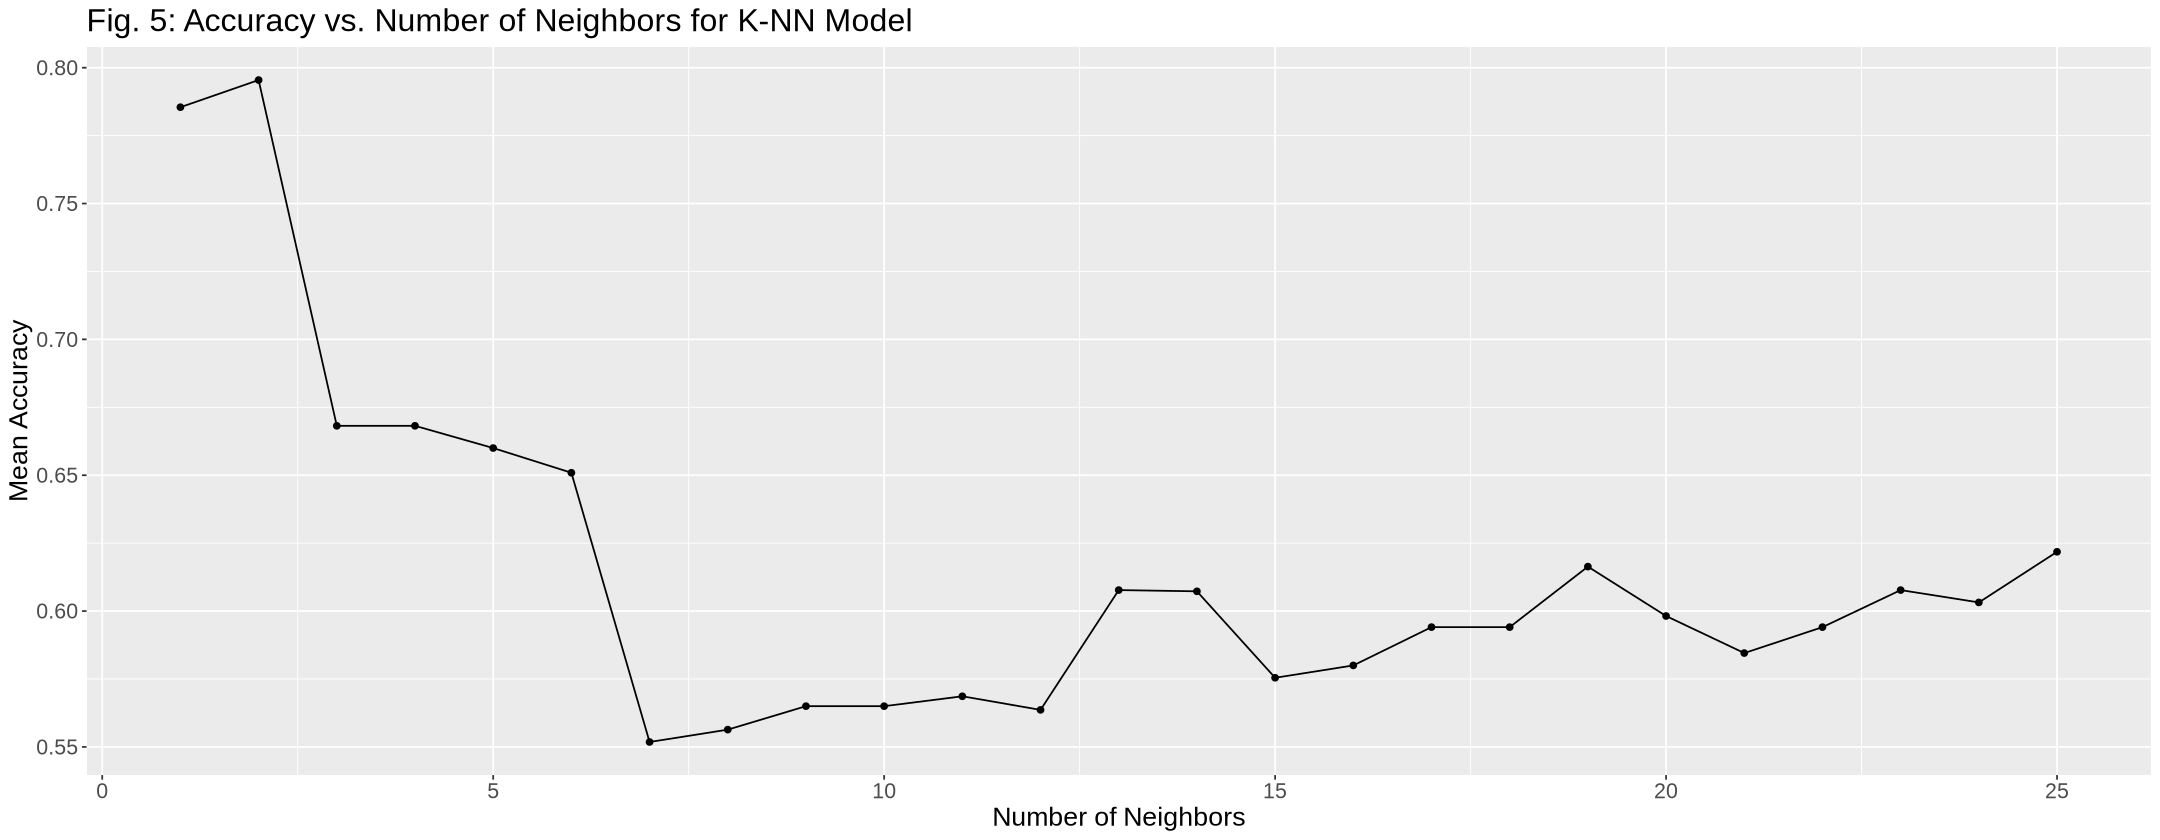

In [92]:
set.seed(1910)

train_balanced <- recipe(subscribe ~ age + mean + play_time + num_sessions + exp_num, data = play_train) |>
    step_upsample(subscribe, over_ratio = 1, skip = FALSE) |>
    prep() |>
    bake(play_train)
play_recipe <- recipe(subscribe ~ age + mean + play_time + num_sessions + exp_num, data = train_balanced) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_impute_mean(all_predictors()) 

play_recipe
k_vals <- tibble(neighbors = seq(from = 1, to = 25, by = 1))

play_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")
play_vfold <- vfold_cv(train_balanced, v = 10, strata = subscribe)

play_metrics <- workflow() |>
    add_recipe(play_recipe) |>
    add_model(play_spec) |>
    tune_grid(resamples = play_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") 


play_plot <- play_metrics |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line()+
    labs(x= "Number of Neighbors", y="Mean Accuracy", title="Fig. 5: Accuracy vs. Number of Neighbors for K-NN Model")+
    theme(text=element_text(size=16))

play_plot


In [91]:
best_k <- play_metrics |>
    arrange(-mean) |>
    head(3)
best_k

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.7954545,10,0.02688273,Preprocessor1_Model02
1,accuracy,binary,0.7854545,10,0.02751408,Preprocessor1_Model01
3,accuracy,binary,0.6681818,10,0.02982964,Preprocessor1_Model03


From fig. 4 and the table above, the best k value is 2. Interestingly, k = 1 and k = 2 outperform a dummy classifier model that predicts TRUE for every single observation (which would give an accuracy of about 0.73, the proportion of subscribers in the data), indicating that this model may have some predictive value. However, these low k values indicate potential overfitting. By testing the model on the testing data and making a confusion matrix, we can determine whether the model performs well on unseen data or if it is simply overfitted to the training data.

In [57]:
set.seed(1019)
final_k_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
      set_engine("kknn") |>
      set_mode("classification")

final_play_workflow <- workflow() |>
    add_recipe(play_recipe) |>
    add_model(final_k_spec) 

final_play_fit <- final_play_workflow|>
    fit(data=train_balanced)


play_test_predictions <- predict(final_play_fit, new_data = play_test)|>
    bind_cols(play_test)

play_mat <- play_test_predictions |> 
      conf_mat(truth = subscribe, estimate = .pred_class)
play_mat

          Truth
Prediction FALSE TRUE
     FALSE     5    7
     TRUE      7   30

Unfortunately, the model only has 71.4% accuracy on the testing data. This is worse than the proportion of TRUE data points in both the testing data, as well as in the training data. The model is remarkably bad at predicting non-subscribers, identifying just 42% of non-subscribers correctly. As well, of its predicted non-subscribers, only 42% of them are actually non-subscribers. This drop in accuracy compared to the testing data indicates that the (relatively) "high" performance of the model on the testing data was simply by random chance, and that it has little predictive value for unseen data. 

For completeness, the precision and recall of the model are equal, at 81%. The specificity, as stated, is 42%.

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


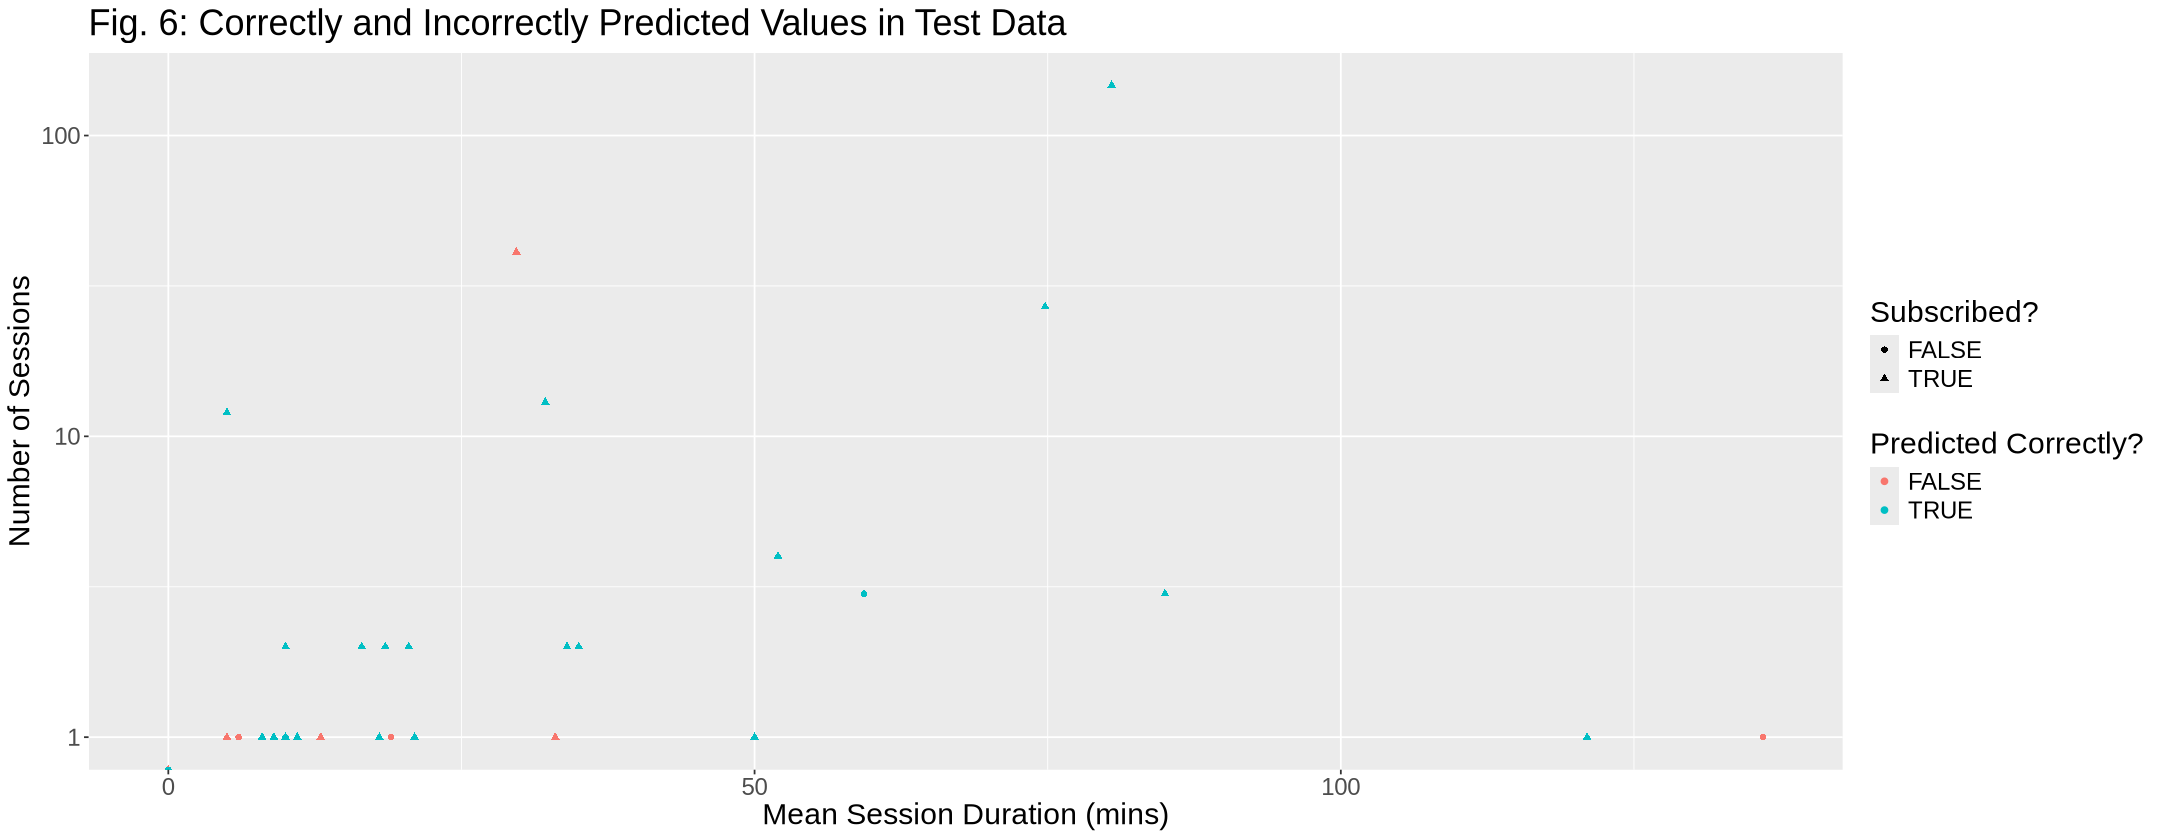

In [99]:
play_test_plot <- play_test_predictions |>
    mutate(truth = subscribe == .pred_class) |>
    ggplot(aes(x = mean, y = num_sessions, color = truth, shape = subscribe)) +
    geom_point() +
    labs(x = "Mean Session Duration (mins)", y = "Number of Sessions", shape = "Subscribed?", color = "Predicted Correctly?") +
    ggtitle("Fig. 6: Correctly and Incorrectly Predicted Values in Test Data") +
    scale_y_log10() +
    theme(text = element_text(size = 18))

play_test_plot

The plot above colour-codes the points in the testing data based on whether they were correctly or incorrectly classified by the model. This plot does not show the individuals who did not play - their subscription status could be quite variable and thus the model made many errors when predicting for these observations. As well, it does not show many other predictors, including age and experience, as this would be impossible. Interestingly, of all the players who played more than one session, the model made only one error - a false negative. Perhaps, the model's strength lies in its use of playing data, and it only performs poorly when there is insufficient data about a player's playing habits. Alternatively, this may simply be because these players are more likely to subscribe, and the model is more likely to predict TRUE than FALSE.

### Contextualization of Results
If the researchers wished to predict who would subscribe, they would likely be better off treating everyone as a future subscriber. If, for some reason, they cared about determining who would NOT subscribe (perhaps to avoid bothering them with requests to subscribe), this model may be slightly better than randomly guessing. From the training data set's relative proportions of subscribers and non-subscribers, about 27% of people are not subscribed. Hence, in the testing set of 49 individuals, about 13 are expected not to be subscribed. Picking 13 at random would correctly identify, on average, 3.5 non-subscribers (13 * 0.27), while this model identified 5. As well, while a model predicting only TRUE would have 76% precision for the testing data (the percentage of TRUE values), this model has 81%, representing the only metric in which it outperforms the dummy classifier. While certainly well beneath the threshold for statistical significance, in a project that has yielded so little, one must grasp at any straw of hope he can to avoid sinking into the despair of futility.

### Improvements
The data set themselves were small, and what data there was was generally not of high quality. Notably, the extreme imbalance in the `age` variable likely reduced its value as a predictor - data for players of a wider range of ages would have improved the value of this variable. As well, with only 196 players, many of whom played very little or not at all., the data set may have been too small to train the model on any patterns that may have been present. Perhaps with more data, this model and these predictors could yield more definitive results. As mentioned above, the model's performance on a data set of highly active players should be investigated.

## Conclusion
The question of subscription prediction could help the PLAICraft team better target their marketing efforts towards demographics more likely to subscribe to their newsletter, helping them build a consistent, returning player base that will contribute large amounts of data to their project. Unfortunately, this investigation, aiming to determine if factors such as age, number of played sessions, average session length, and experience level could predict subscription, did not return any meaningful results.

## References
